In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivaravi","key":"1d193a1dab9c5ac6c4cf3e8a95e7fecc"}'}

In [0]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c facebook-recruiting-iii-keyword-extraction

100% 2.18G/2.19G [00:19<00:00, 122MB/s]
100% 2.19G/2.19G [00:19<00:00, 122MB/s]
100% 725M/725M [00:11<00:00, 53.1MB/s]
100% 725M/725M [00:11<00:00, 65.4MB/s]
  0% 0.00/4.81M [00:00<?, ?B/s]
100% 4.81M/4.81M [00:00<00:00, 44.3MB/s]


In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import os
from datetime import datetime
import datetime as dt
from sqlalchemy import create_engine
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [0]:
train = pd.read_csv('/content/drive/My Drive/shiva/stackoverflow/Train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [0]:
if not os.path.isfile('train.db'):
    disk_engine = create_engine("sqlite:///train.db")
    #train_data = pd.DataFrame(train, columns=['Id','Title', 'Body', 'Tags'])
    train.to_sql('data',disk_engine)

In [5]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034195
Time taken to count the number of rows : 0:00:14.578140


In [6]:
if os.path.isfile('train.db'):
    start=datetime.now()
    con=sqlite3.connect('train.db')
    df_no_dup=pd.read_sql_query("""select Title,Body,Tags,count(*) as no_of_dup from data GROUP BY Title, Body, Tags""",con)
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Time taken to count the number of rows : 0:04:51.894651


In [7]:
df_no_dup.no_of_dup.value_counts()

1    2656283
2    1272336
3     277575
4         90
5         25
6          5
Name: no_of_dup, dtype: int64

In [8]:
print("number of duplicate questions:", num_rows['count(*)'].values[0]-df_no_dup.shape[0],"(",round((1-(df_no_dup.shape[0]/num_rows['count(*)'].values[0]))*100,2),"% )")

number of duplicate questions: 1827881 ( 30.29 % )


In [9]:
sum(df_no_dup["Tags"].isnull())

7

In [10]:
df_no_dup=df_no_dup[df_no_dup.Tags.notnull()]
df_no_dup.shape

(4206307, 4)

In [11]:
df_no_dup["tag_count"]=df_no_dup["Tags"].apply(lambda x: len(x.split(" ")))
df_no_dup.head()

,Title,Body,Tags,no_of_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [12]:
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568290
5     505158
Name: tag_count, dtype: int64

In [0]:
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [14]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:02:30.423966


In [15]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm=vectorizer.fit_transform(tag_data["Tags"])
tag_dtm.shape

(4206306, 42048)

In [16]:
tags=vectorizer.get_feature_names()
print(tags[:10])

['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [0]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [18]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [0]:
tag_df_sorted=tag_df.sort_values(['Counts'],ascending=False)
tag_df_count=tag_df_sorted['Counts'].values

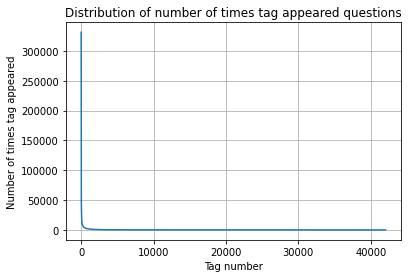

In [20]:
plt.plot(tag_df_count)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

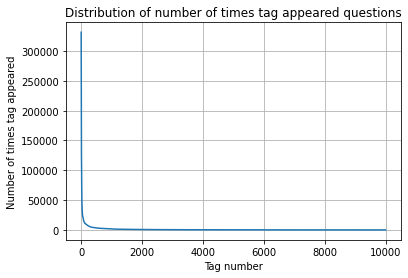

In [21]:
plt.plot(tag_df_count[0:10000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

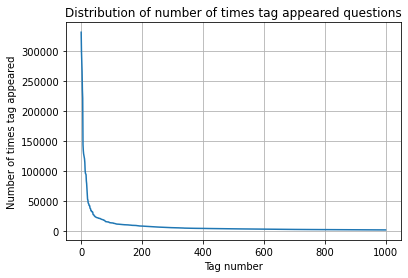

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3482
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [22]:
plt.plot(tag_df_count[0:1000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_df_count[0:1000:5]), tag_df_count[0:1000:5])

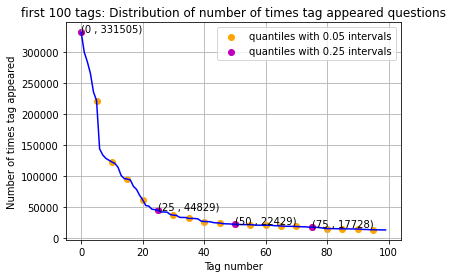

In [23]:
plt.plot(tag_df_count[0:100],c='b')
plt.scatter(x=list(range(0,100,5)),y=tag_df_count[0:100:5],c='orange',label="quantiles with 0.05 intervals")
plt.scatter(x=list(range(0,100,25)),y=tag_df_count[0:100:25],c='m',label="quantiles with 0.25 intervals")
for x,y in zip(list(range(0,100,25)), tag_df_count[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))
plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.legend()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

Observations:

1.There are total 153 tags which are used more than 10000 times.  
2.14 tags are used more than 100000 times.  
3.Most frequent tag (i.e. c#) is used 331505 times.  
4.Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

In [24]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))
print(tag_quest_count[:5])

We have total 4206306 datapoints.
[3, 4, 2, 2, 3]


In [25]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899443


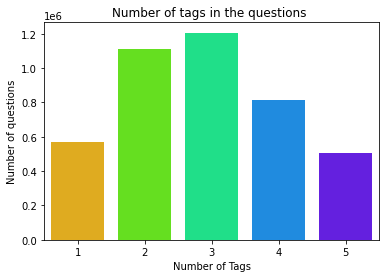

In [26]:
sns.countplot(tag_quest_count,palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

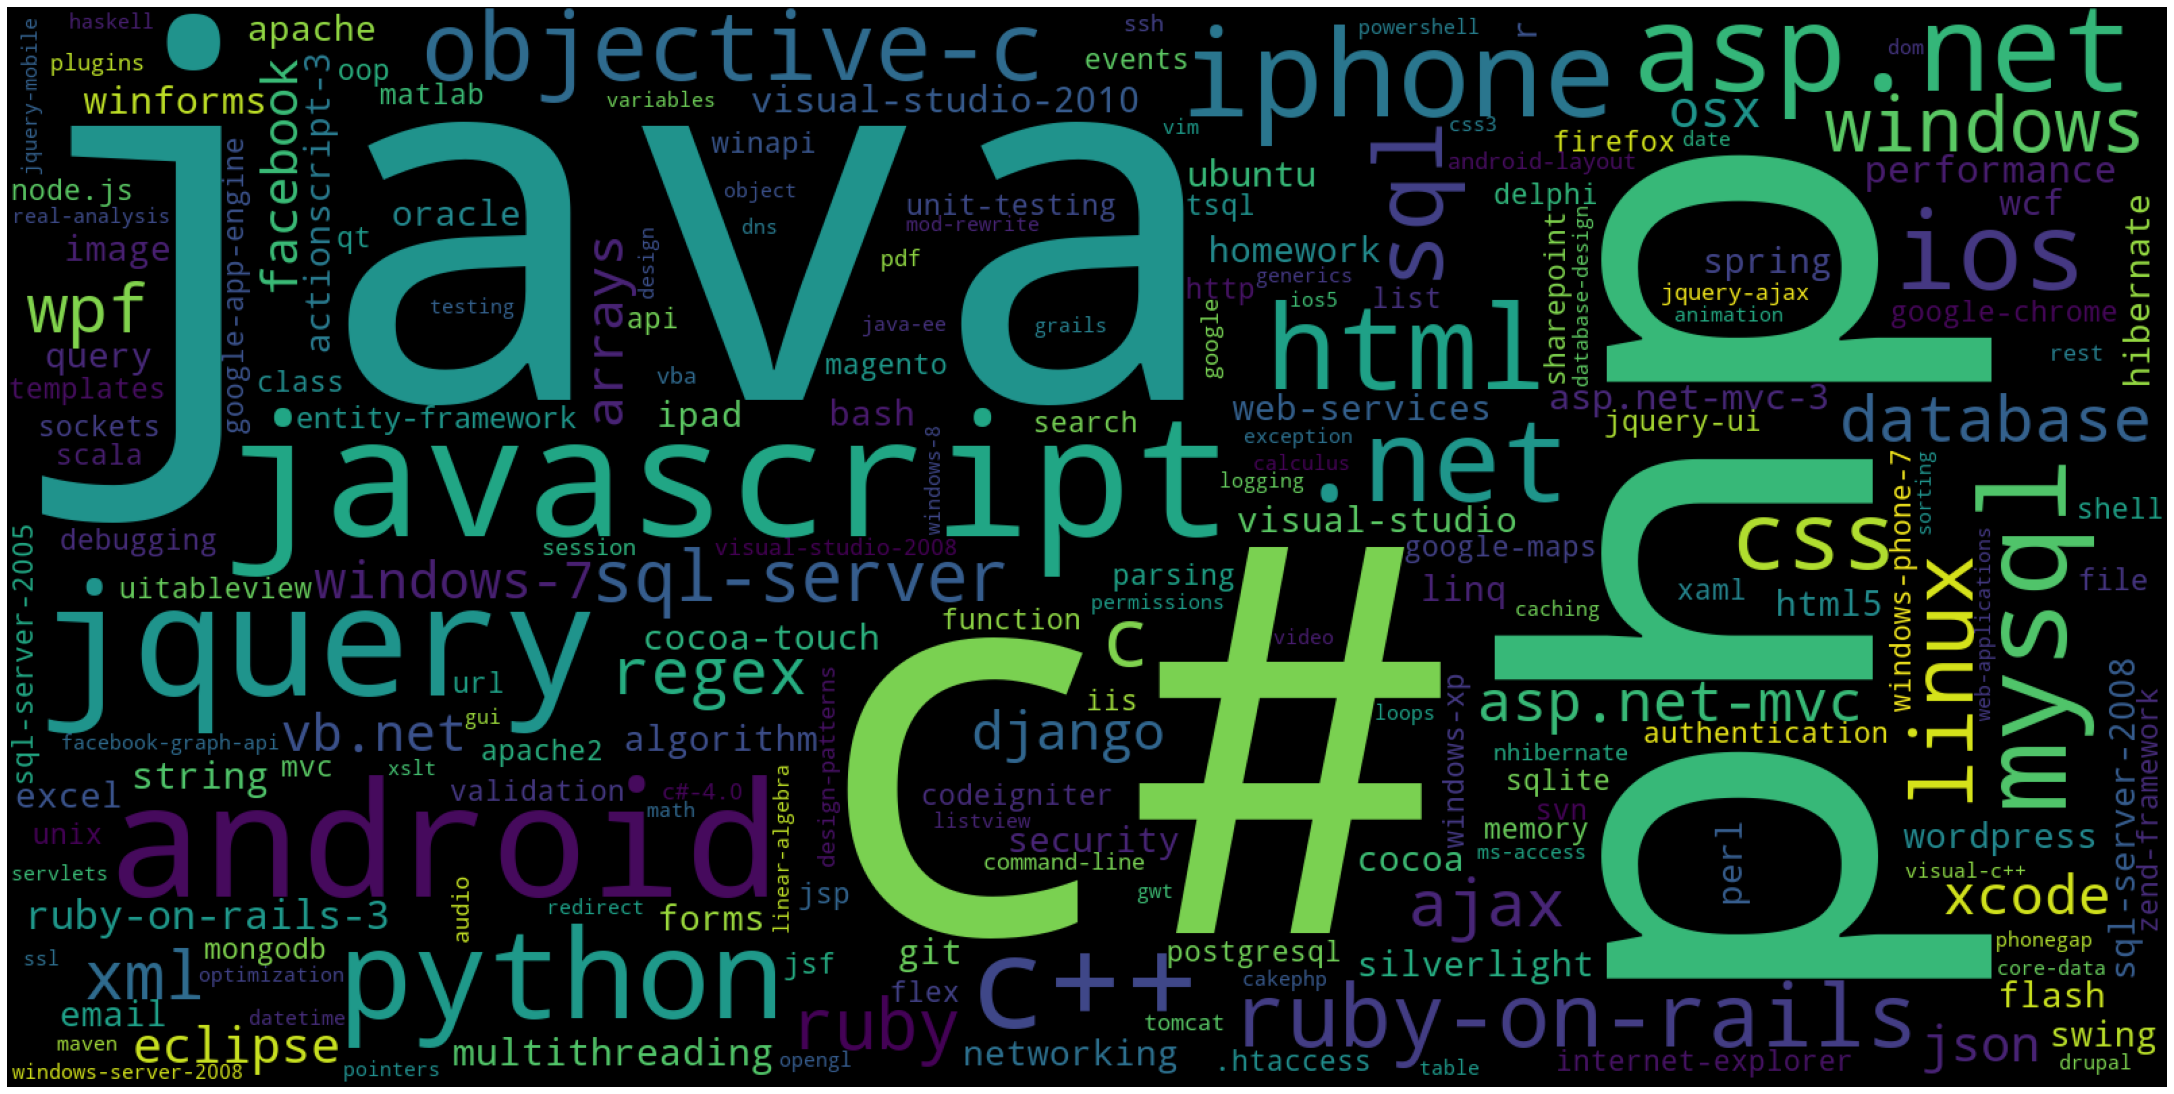

In [27]:
# Lets first convert the 'result' dictionary to 'list of tuples'
tup=dict(result.items())
wordcloud=WordCloud(background_color='black',width=1600,height=800).generate_from_frequencies(tup)
fig=plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

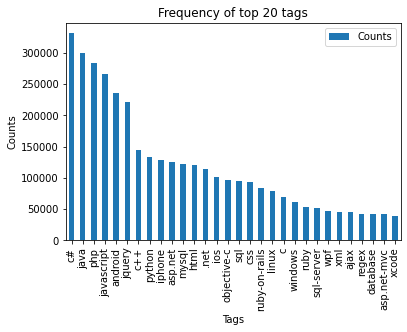

In [28]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [29]:
import nltk
nltk.download('stopwords')
def striphtml(data):
  cleanr=re.compile('<.*?>')
  cleantext=re.sub(cleanr," ",str(data))
  return cleantext
stop_words=set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
def create_connection(db_file):
  try:
    conn=sqlite3.connect(db_file)
    return conn
  except Error as e:
    print(e)
    return None
def create_table(conn,create_table_sql):
  try:
    c=conn.cursor()
    c.execute(create_table_sql)
  except Error as e:
    print(e)
def checkTableExists(dbcon):
  cursr=dbcon.cursor()
  str = "select name from sqlite_master where type='table'"
  table_names=cursr.execute(str)
  print('Tables in the database:')
  tables=table_names.fetchall()
  print(tables[0][0])
  return(len(tables))
def create_database_table(database,query):
  conn=create_connection(database)
  if conn is not None:
    create_table(conn,query)
    checkTableExists(conn)
  else:
    print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the database:
QuestionsProcessed


In [36]:
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the database:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:03:36.864549


In [37]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
Avg. length of questions(Title+Body) before processing: 1170
Avg. length of questions(Title+Body) after processing: 397
Percent of questions containing code: 57
Time taken to run this cell : 0:33:03.002103


In [33]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [39]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('mysql time comparison strang result mysql time comparison strang result mysql time comparison strang result use timestamp field set current time insert follow entri execut nselect list timestampfield return empti result set expect entri enter execut nselect list timestampfield get could tell proper way get entri previous hour thank',)
----------------------------------------------------------------------------------------------------
('technolog use access jira technolog use access jira technolog use access jira go use jira rest java client programat access jira java use jira rest api support jira later version jira version want programat interfac non site list various technolog like rest xml rpc soap etc know use work anyon point correct technolog use',)
----------------------------------------------------------------------------------------------------
('convert unicod charact twitter json api feed use coldfus convert unicod charact twitter json api fee

In [0]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [41]:
preprocessed_data.head()

,question,tags
0,delet file creat window servic run domain user...,windows-server-2008-r2 file-permissions cruise...
1,mysql time comparison strang result mysql time...,mysql timestamp
2,technolog use access jira technolog use access...,java jira jira-rest-java-api
3,convert unicod charact twitter json api feed u...,regex json api twitter coldfusion
4,possibl programmat talk msn messeng live messe...,api msn


In [0]:
preprocessed_data.to_csv('/content/drive/My Drive/shiva/stackoverflow/preprocessed_data.csv')

In [0]:
write_db = 'train_no_dup.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        test_data = pd.read_sql_query("""SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000""", conn_r)
conn_r.commit()
conn_r.close()

In [0]:
test_data.head()

,Title,Body,Tags
0,How to access codeigniter user defined models ...,<blockquote>\n <p><strong>Possible Duplicate:...,codeigniter
1,Eclipse pausing without a breakpoint on gettin...,"<p>While debugging, my Eclipse pause on same l...",java eclipse hibernate debugging breakpoints
2,Deserializing JSON TweetSharp TwitterStatus,<p>I'm using Daniel Crenna's TweetSharp <a hre...,json serialization newtonsoft tweetsharp
3,Prototype Element.update multiple objects,<p>I'm trying to construct a table with Protot...,constructor prototypejs append
4,How to preserve the ModelMap between form subm...,<p>I am adding to the <code>ModelMap</code> a ...,java web-applications spring-mvc


In [0]:
preprocessed_data = pd.read_csv('/content/drive/My Drive/shiva/stackoverflow/preprocessed_data.csv',index_col = False)

In [0]:
preprocessed_data = preprocessed_data.loc[:, ~preprocessed_data.columns.str.contains('^Unnamed')]

In [5]:
preprocessed_data.head()

,question,tags
0,delet file creat window servic run domain user...,windows-server-2008-r2 file-permissions cruise...
1,mysql time comparison strang result mysql time...,mysql timestamp
2,technolog use access jira technolog use access...,java jira jira-rest-java-api
3,convert unicod charact twitter json api feed u...,regex json api twitter coldfusion
4,possibl programmat talk msn messeng live messe...,api msn


In [0]:
vectorizer=CountVectorizer(tokenizer=lambda x:x.split(),binary=True)
multilabel_y=vectorizer.fit_transform(preprocessed_data['tags'])

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

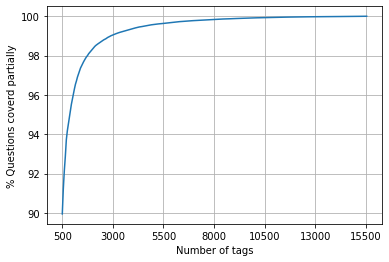

with  5500 tags we are covering  99.048 % of questions
with  500 tags we are covering  89.954 % of questions


In [9]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("% Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [10]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 50229 out of  499996


In [18]:
from sklearn.externals import joblib
joblib.dump(preprocessed_data, 'preprocessed_data.pkl')

['preprocessed_data.pkl']

In [0]:
import pandas as pd

data = pd.read_pickle('/content/drive/My Drive/shiva/stackoverflow/preprocessed_data.pkl')

In [0]:
from sklearn.externals import joblib
preprocessed_data=joblib.load("preprocessed_data.pkl")

In [0]:
train_datasize=400000
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [13]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (99996, 500)


In [22]:
#Featurizing data with TfIdf vectorizer
start=datetime.now()
vectorizer=TfidfVectorizer(min_df=0.0009,max_features=200000,smooth_idf=True,tokenizer = lambda x: x.split(),ngram_range=(1,4))
x_train_multilabel=vectorizer.fit_transform(x_train["question"])
x_test_multilabel=vectorizer.transform(x_test["question"])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:07:40.325783


In [23]:
#OneVsRest Classifier with SGDClassifier using TFIDF
start=datetime.now()
classifier=OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1',alpha=0.00001,),n_jobs=-1)

classifier.fit(x_train_multilabel,y_train)
predictions=classifier.predict(x_test_multilabel)

print("Accuracy:",metrics.accuracy_score(y_test,predictions))
print("Hamming loss:",metrics.hamming_loss(y_test,predictions))

precision=precision_score(y_test,predictions,average='micro')
recall=recall_score(y_test,predictions,average='micro')
f1=f1_score(y_test,predictions,average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy: 0.23086923476939078
Hamming loss: 0.002840733629345174
Micro-average quality numbers
Precision: 0.7212, Recall: 0.3456, F1-measure: 0.4672
Macro-average quality numbers
Precision: 0.5305, Recall: 0.2584, F1-measure: 0.3299
              precision    recall  f1-score   support

           0       0.62      0.26      0.37      7786
           1       0.80      0.43      0.56      7056
           2       0.85      0.55      0.66      6885
           3       0.77      0.43      0.55      6493
           4       0.94      0.74      0.83      5654
           5       0.87      0.62      0.72      5388
           6       0.70      0.34      0.46      3276
           7       0.90      0.59      0.71      3102
           8       0.70      0.40      0.51      2974
           9       0.82      0.41      0.55      2917
          10       0.88      0.61      0.72      2888
          11       0.55      0.20      0.29      2861
          12       0.58      0.11      0.19      2651
          

In [24]:
joblib.dump(classifier, 'lr_with_more_title_weight.pkl')

['lr_with_more_title_weight.pkl']

In [28]:
#Applying Logistic Regression with LogisticRegression and OneVsRest Classifier

start = datetime.now()
classifier2 = OneVsRestClassifier(LogisticRegression(penalty='l1',solver='liblinear'), n_jobs=-1)
classifier2.fit(x_train_multilabel, y_train)
predictions_2 = classifier2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))

precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23843953758150327
Hamming loss  0.0028061522460898435

Micro-average quality numbers
Precision: 0.7124, Recall: 0.3716, F1-measure: 0.4884

Macro-average quality numbers
Precision: 0.5460, Recall: 0.2893, F1-measure: 0.3619

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.29      0.40      7786
           1       0.79      0.46      0.58      7056
           2       0.84      0.57      0.68      6885
           3       0.77      0.44      0.56      6493
           4       0.94      0.77      0.85      5654
           5       0.86      0.63      0.73      5388
           6       0.70      0.38      0.49      3276
           7       0.89      0.59      0.71      3102
           8       0.69      0.43      0.53      2974
           9       0.81      0.43      0.56      2917
          10       0.87      0.63      0.73      2888
          11       0.55      0.22      0.31      2861
          12       0.55      0.12    

In [30]:
joblib.dump(classifier2, 'lr_with_more_title_weight2.pkl')

['lr_with_more_title_weight2.pkl']

In [16]:
#Featurizing Using Bag of Words
start=datetime.now()
vectorizer=CountVectorizer(min_df=0.00009, max_features=100000,analyzer='word',tokenizer = lambda x: x.split(),ngram_range=(1,4))
x_train_multilabel=vectorizer.fit_transform(x_train["question"])
x_test_multilabel=vectorizer.transform(x_test["question"])
print("Time taken to run this cell :", datetime.now() - start)

#Sorting indices to get rid of Value Error: WRITEBACKIFCOPY base is read-only
x_train_multilabel.sort_indices()
x_test_multilabel.sort_indices()

print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Time taken to run this cell : 0:06:28.084033
Number of data points in train data : (400000, 500)
Number of data points in test data : (99996, 500)


In [36]:
joblib.dump(x_train_multilabel, 'x_train_BOW.pkl') 
joblib.dump(x_test_multilabel, 'x_test_BOW.pkl')
joblib.dump(y_train, 'y_train_BOW.pkl')
joblib.dump(y_test, 'y_test_BOW.pkl')

['y_test_BOW.pkl']

In [37]:
#Applying Logistic Regression with SGDClassifier and OneVsRest Classifier

start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(penalty='l1', C=1.0, random_state=0,solver='liblinear'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Micro F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Macro F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to train the model :", datetime.now() - start)

Accuracy : 0.21344853794151766
Hamming loss  0.0031795271810872434
Micro-average quality numbers
Precision: 0.5791, Recall: 0.4318, Micro F1-measure: 0.4947
Macro-average quality numbers
Precision: 0.4637, Recall: 0.3531, Macro F1-measure: 0.3981
              precision    recall  f1-score   support

           0       0.52      0.41      0.46      7786
           1       0.66      0.53      0.59      7056
           2       0.73      0.62      0.67      6885
           3       0.64      0.51      0.57      6493
           4       0.91      0.82      0.86      5654
           5       0.78      0.66      0.72      5388
           6       0.58      0.45      0.51      3276
           7       0.83      0.67      0.74      3102
           8       0.61      0.49      0.54      2974
           9       0.66      0.49      0.56      2917
          10       0.77      0.67      0.71      2888
          11       0.43      0.31      0.36      2861
          12       0.31      0.20      0.24      2

In [38]:
joblib.dump(classifier, 'lr_with_more_title_weight_lr_ovr.pkl')

['lr_with_more_title_weight_lr_ovr.pkl']

In [39]:
#Applying Logistic Regression (SGDClassifier with 'log' loss) with OneVsRest Classifier
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l1', random_state=0), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Micro F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Macro F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to train the model :", datetime.now() - start)

Accuracy : 0.1982679307172287
Hamming loss  0.0031165246609864395
Micro-average quality numbers
Precision: 0.6348, Recall: 0.3190, Micro F1-measure: 0.4246
Macro-average quality numbers
Precision: 0.4317, Recall: 0.2380, Macro F1-measure: 0.2896
              precision    recall  f1-score   support

           0       0.50      0.11      0.18      7786
           1       0.75      0.46      0.57      7056
           2       0.82      0.51      0.63      6885
           3       0.79      0.37      0.51      6493
           4       0.91      0.72      0.80      5654
           5       0.86      0.59      0.70      5388
           6       0.60      0.26      0.36      3276
           7       0.90      0.56      0.69      3102
           8       0.74      0.33      0.46      2974
           9       0.75      0.35      0.48      2917
          10       0.84      0.59      0.70      2888
          11       0.45      0.16      0.23      2861
          12       0.44      0.10      0.16      26

In [0]:
#Hyperparameter 'alpha' tuning to increase performance on Logistic Regression model (SGDClassifier with 'log' loss) with OneVsRest Classifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

# start=datetime.now()

# def random_search(x_train_multilabel,y_train):
#   n_folds=3
#   cv_kfold=KFold(n_splits=n_folds).split(x_train_multilabel)
#   alpha=[10**-4,10**-3,10**-2,10**-1]
#   params={"estimator__alpha":alpha}
#   base_estimator=OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1',random_state=0),n_jobs=-1)
#   rsearch_cv=RandomizedSearchCV(estimator=base_estimator,param_distributions=params,verbose=1,n_jobs=-1,cv=cv_kfold,n_iter=15,scoring='f1_micro')
#   rsearch_cv.fit(x_train_multilabel,y_train)
#   return rsearch_cv

#   #Get the best estimator after performing Random Search Cross Validation.
# rsearch_cv = random_search(x_train_multilabel,y_train)

# print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
# print("Best estimator: ",rsearch_cv.best_estimator_)
# print("Best Cross Validation Score: ",rsearch_cv.best_score_)

In [19]:
# Applying Linear-SVM (SGDClassifier with 'hinge' loss) with OneVsRest Classifier
start = datetime.now()

#Build the model
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1', verbose=1), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Micro F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Macro F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to train the model :", datetime.now() - start)

#Save the model for future use.
import joblib
joblib.dump(classifier, 'linear_SVM_with_more_title_weight_sgd_hinge_ovr.pkl')

Accuracy : 0.12705508220328812
Hamming loss  0.0047239889595583825
Micro-average quality numbers
Precision: 0.3749, Recall: 0.4651, Micro F1-measure: 0.4151
Macro-average quality numbers
Precision: 0.2787, Recall: 0.3915, Macro F1-measure: 0.3230
              precision    recall  f1-score   support

           0       0.45      0.44      0.44      7786
           1       0.57      0.56      0.56      7056
           2       0.63      0.64      0.64      6885
           3       0.55      0.53      0.54      6493
           4       0.84      0.85      0.84      5654
           5       0.69      0.68      0.68      5388
           6       0.47      0.48      0.47      3276
           7       0.68      0.71      0.69      3102
           8       0.50      0.51      0.50      2974
           9       0.51      0.53      0.52      2917
          10       0.66      0.69      0.67      2888
          11       0.32      0.31      0.32      2861
          12       0.23      0.23      0.23      2

['linear_SVM_with_more_title_weight_sgd_hinge_ovr.pkl']

In [2]:
from IPython.core.display import display,HTML

from prettytable import PrettyTable

#Table 1
print("Conclusion:")
print("="*33)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro f1"]
table.add_row(["SGDClassifier(loss=log)", 'TF-IDF', 0.2308,0.0028,0.7212,0.3456,0.4672])
table.add_row(["LogisticRegression", 'TF-IDF', 0.2384,0.0028,0.7124,0.3716,0.4884])
table.add_row(["LogisticRegression", 'BOW', 0.2134,0.0031,0.5791,0.4318,0.4947])
table.add_row(["SGDClassifier(loss=log)", 'BOW', 0.1982,0.0047,0.6348,0.3190,0.4246])
table.add_row(["SGDClassifier(loss=hinge)", 'BOW', 0.1270,0.0031,0.3749,0.4651,0.4151])

print(table)
print("="*93+"\n"+"="*93+"\n\n")

Conclusion:
+---------------------------+------------+----------+--------------+-----------+--------+----------+
|           Model           | Vectorizer | Accuracy | Hamming loss | Precision | Recall | Micro f1 |
+---------------------------+------------+----------+--------------+-----------+--------+----------+
|  SGDClassifier(loss=log)  |   TF-IDF   |  0.2308  |    0.0028    |   0.7212  | 0.3456 |  0.4672  |
|     LogisticRegression    |   TF-IDF   |  0.2384  |    0.0028    |   0.7124  | 0.3716 |  0.4884  |
|     LogisticRegression    |    BOW     |  0.2134  |    0.0031    |   0.5791  | 0.4318 |  0.4947  |
|  SGDClassifier(loss=log)  |    BOW     |  0.1982  |    0.0047    |   0.6348  | 0.319  |  0.4246  |
| SGDClassifier(loss=hinge) |    BOW     |  0.127   |    0.0031    |   0.3749  | 0.4651 |  0.4151  |
+---------------------------+------------+----------+--------------+-----------+--------+----------+


